<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/task2b_qiskit_custom_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSE802 – Assessment 2, Task 2B (Custom Circuit + Manual QASM)

**Goal:** Hand-write OpenQASM 2.0 → save as `my_custom_circuit.qasm`, load with Qiskit, run locally and via Quokka, visualize and interpret.

In [1]:
!pip -q install qiskit==1.2.4 qiskit-aer==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 982.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### OpenQASM 2.0 Helpers (Qiskit 1.x)

Qiskit 1.x removed `QuantumCircuit.qasm()`.  
Use `qiskit.qasm2.dumps(circuit)` to export and `qiskit.qasm2.loads(text)` (or `load(file)`) to import.
Below we provide small wrappers for convenience and backward-compatibility.


### Save Path (Colab-safe)
We'll save the QASM file in a directory that exists in Colab.
Change `SAVE_DIR` if you'd like to save to Google Drive.


In [3]:
from pathlib import Path
# Default: current working directory (/content in Colab)
SAVE_DIR = Path.cwd()

# If you prefer Google Drive, uncomment below:
# from google.colab import drive
# drive.mount('/content/drive')
# SAVE_DIR = Path('/content/drive/MyDrive/MSE802_Task2')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

QASM_PATH = SAVE_DIR / "my_custom_circuit.qasm"
print("Saving/Loading QASM at:", QASM_PATH)

Saving/Loading QASM at: /content/my_custom_circuit.qasm


In [4]:
# QASM2 helper functions
try:
    from qiskit import qasm2
except Exception as _e:
    qasm2 = None

def to_qasm2(circ):
    """Return OpenQASM 2.0 string for a circuit in Qiskit 1.x+.
    Falls back to old .qasm() if available (older Qiskit).
    """
    if qasm2 is not None:
        return qasm2.dumps(circ)
    # fallback for older versions (<1.0)
    if hasattr(circ, "qasm"):
        return circ.qasm()
    raise RuntimeError("No QASM exporter available. Please install Qiskit>=1.0 or downgrade to 0.46.x.")

def from_qasm2_text(text):
    """Parse OpenQASM 2.0 string into a QuantumCircuit in Qiskit 1.x+.
    Falls back to QuantumCircuit.from_qasm_str for older versions.
    """
    from qiskit import QuantumCircuit
    if qasm2 is not None:
        return qasm2.loads(text)
    if hasattr(QuantumCircuit, "from_qasm_str"):
        return QuantumCircuit.from_qasm_str(text)
    raise RuntimeError("No QASM2 loader available. Install Qiskit>=1.0 or use an older API.")


### Drawer Dependencies (Matplotlib)
Install extras required for `qc.draw('mpl')`.

In [5]:
# Install the Matplotlib drawer dependencies
!pip -q install pylatexenc matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import json, os, requests, warnings
warnings.filterwarnings('ignore')

### Quokka Access (from attached pattern)

The helper below mirrors the *exact* submission style from the provided Quokka access notebook:
- Endpoint: `http://quokka1.quokkacomputing.com/qsim/qasm`
- Headers: `{"Content-Type": "application/json"}`
- Body shape: `script_count`


In [7]:
# Helper that mirrors the attached Quokka access notebook
import json, requests

QUOKKA_ENDPOINT = "http://quokka1.quokkacomputing.com/qsim/qasm"
DEFAULT_HEADERS = {"Content-Type": "application/json"}

def quokka_submit(qasm_source: str, shots: int = 1024, headers: dict = None):
    if headers is None:
        headers = DEFAULT_HEADERS
    payload = {"script": qasm_source, "count": int(shots)}
    r = requests.post(QUOKKA_ENDPOINT, json=payload, headers=headers, verify=False, timeout=120)
    try:
        return r.json()
    except Exception:
        return {"raw_text": r.text, "status_code": r.status_code}


## Create Manual OpenQASM 2.0 (GHZ-like)

In [8]:
qasm_manual='''\
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
// GHZ-like prep
h q[0];
cx q[0],q[1];
cx q[1],q[2];
// Measure all
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
'''.strip()
with open(str(QASM_PATH),'w',encoding='utf-8') as f:
    f.write(qasm_manual)
print('Saved /mnt/data/my_custom_circuit.qasm')
print('\n'.join(qasm_manual.splitlines()[:12]))

Saved /mnt/data/my_custom_circuit.qasm
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
// GHZ-like prep
h q[0];
cx q[0],q[1];
cx q[1],q[2];
// Measure all
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];


## Load into Qiskit and Visualize

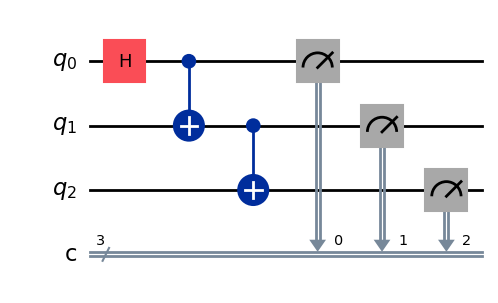

In [9]:
with open(str(QASM_PATH),'r',encoding='utf-8') as _f:
    _txt = _f.read()
qc_custom = from_qasm2_text(_txt)
qc_custom.draw('mpl')

## Local Execution (Aer)

Local counts (custom): {'111': 1036, '000': 1012}


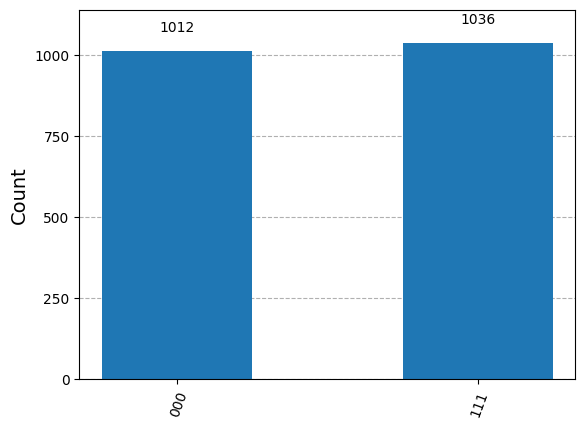

In [10]:
backend = Aer.get_backend('qasm_simulator')
shots=2048
job = backend.run(qc_custom, shots=shots)
result = job.result()
counts_local_custom = result.get_counts(qc_custom)
print('Local counts (custom):', counts_local_custom)
plot_histogram(counts_local_custom)

### Quokka Helper

In [11]:
import json, requests

def quokka_submit(qasm_source: str, shots: int = 1024, endpoint: str = 'http://quokka1.quokkacomputing.com/qsim/qasm', headers: dict = None):
    if headers is None:
        headers = {'Content-Type': 'application/json'}
    data={'script': qasm_source, 'count': int(shots)}
    try:
        resp = requests.post(endpoint, json=data, headers=headers, verify=False, timeout=120)
        status = resp.status_code
        try:
            payload = resp.json()
        except Exception:
            payload = {'raw_text': resp.text}
        print(f'[Quokka] Status: {status}')
        return payload
    except Exception as e:
        print('[Quokka] Error:', repr(e))
        return {'error': str(e)}

## Send Manual QASM to Quokka

In [12]:
with open(str(QASM_PATH),'r',encoding='utf-8') as f:
    qasm_text=f.read()
quokka_resp_custom = quokka_submit(qasm_text, shots=1024)
print(json.dumps(quokka_resp_custom, indent=2)[:1200])

[Quokka] Status: 200
{
  "error": "no error",
  "error_code": 0,
  "result": {
    "c": [
      [
        1,
        1,
        1
      ],
      [
        1,
        1,
        1
      ],
      [
        1,
        1,
        1
      ],
      [
        1,
        1,
        1
      ],
      [
        0,
        0,
        0
      ],
      [
        0,
        0,
        0
      ],
      [
        0,
        0,
        0
      ],
      [
        0,
        0,
        0
      ],
      [
        1,
        1,
        1
      ],
      [
        1,
        1,
        1
      ],
      [
        1,
        1,
        1
      ],
      [
        0,
        0,
        0
      ],
      [
        0,
        0,
        0
      ],
      [
        1,
        1,
        1
      ],
      [
        0,
        0,
        0
      ],
      [
        1,
        1,
        1
      ],
      [
        0,
        0,
        0
      ],
      [
        1,
        1,
        1
      ],
      [
        0,
        0

## Interpret/Visualize Quokka Results

In [13]:
from collections import Counter

def try_extract_counts(obj):
    if isinstance(obj, dict):
        if 'counts' in obj and isinstance(obj['counts'], dict):
            return {str(k): int(v) for k,v in obj['counts'].items()}
        if 'results' in obj and isinstance(obj['results'], dict) and 'counts' in obj['results']:
            return {str(k): int(v) for k,v in obj['results']['counts'].items()}
    if isinstance(obj, list):
        return dict(Counter([str(x) for x in obj]))
    return None

counts_quokka_custom = try_extract_counts(quokka_resp_custom)
if counts_quokka_custom:
    print('Quokka counts (custom):', counts_quokka_custom)
    plot_histogram(counts_quokka_custom)
else:
    print('No parseable counts returned from Quokka.')

No parseable counts returned from Quokka.


### Screenshot Note
Insert a screenshot of your circuit diagram here (or save the mpl output).

### Interpretation (Part 2B)
- H creates superposition; chained CX spreads correlation → GHZ-like.
- Expect mass on 000 and 111. Differences reflect sampling and backend.

## (Optional) Quokka Async Poller

Some deployments return a `job_id` and require polling. This helper tries both patterns:
1) Immediate JSON with `counts`
2) `job_id` → poll `/jobs/<id>` until `SUCCEEDED`

If your service uses another path, tweak `STATUS_PATH` accordingly.


In [ ]:
import time, requests, json

def quokka_submit_or_poll(qasm_source: str, shots: int = 1024,
                          endpoint: str = "http://quokka1.quokkacomputing.com/qsim/qasm",
                          headers: dict = None,
                          status_path_template: str = "http://quokka1.quokkacomputing.com/jobs/{job_id}"):
    if headers is None:
        headers = {"Content-Type": "application/json"}
    data = {"script": qasm_source, "count": int(shots)}
    r = requests.post(endpoint, json=data, headers=headers, verify=False, timeout=120)
    try:
        j = r.json()
    except Exception:
        return {"status_code": r.status_code, "raw_text": r.text}

    # Case 1: counts already present
    if isinstance(j, dict) and ("counts" in j or ("results" in j and isinstance(j["results"], dict) and "counts" in j["results"])):
        return j

    # Case 2: async job id
    job_id = j.get("job_id") or j.get("id")
    if not job_id:
        return j  # unknown shape; return as-is for inspection

    status_url = status_path_template.format(job_id=job_id)
    deadline = time.time() + 180
    while time.time() < deadline:
        s = requests.get(status_url, headers=headers, verify=False, timeout=60)
        try:
            sj = s.json()
        except Exception:
            return {"poll_raw_text": s.text, "status_url": status_url}

        state = (sj.get("state") or sj.get("status") or "").upper()
        if state in {"SUCCEEDED", "COMPLETED", "DONE"}:
            return sj.get("result") or sj.get("results") or sj
        if state in {"FAILED", "CANCELLED", "ERROR"}:
            return {"error": f"Job {job_id} ended with state={state}", "full": sj}
        time.sleep(2.0)
    return {"error": "Timeout waiting for job", "job_id": job_id, "status_url": status_url}
